# Using NLP to Identify Works by Shakespeare

The data for this project includes the ten works with the highest word counts. By using excerpts from the corpus the model will try to predict which play they are from using various processing techniques such as word2vec and tf-idf.

| Work | Word Count   |
|------|------|
|   Hamlet  | 30,557 |
|   Richard III  | 29,278 |
|   Coriolanus  | 27,589 |
|   Cymbeline  | 27,565 |
|   Othello  | 26,450 |
|   King Lear  | 26,145 |
|   Henry V  | 26,119 |
|   Troilus and Cressida  | 26,089 |
|   Henry IV, Part II   | 25,689 |
|   Henvry VI, Part II  | 25,483 |

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from nltk.corpus import stopwords
from collections import Counter

# Pre-Processing

In [8]:
# Utility functions for cleaning text.
def text_cleaner(text):
    
    # Cleaning out '--'.
    text = re.sub(r'--', ' ', text)
    
    # Removing = signs
    text = re.sub(r'=', ' ', text)
    
    # Getting rid of headings in square brackets.
    text = re.sub("[\[].*?[\]]", "", text)
    
    # Getting rid of act and scene titles.
    text = re.sub(r'(ACT \d+)', '', text)
    text = re.sub(r'(Act \d+)', '', text)
    
    text = re.sub(r'(Scene \d+)', '', text)
    text = re.sub(r'(SCENE \d+)', '', text)
    
    # Removeing speaking directions
    text = re.sub(r'\b[A-Z]+\b', '', text)
    
    # Getting rid of extra whitespace.
    text = ' '.join(text.split())
    
    return text

def lemma(text):
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return text

Outside of general text cleaning, character speaking queues were also removed. I assumed that if given to the models would correlate too strongly with the correct classification.

In [9]:
# Function for loading in the texts
def loader(name):
    path = 'G:/projects/thinkful/spear/'
    with open(path + name) as f:
        text = f.read()
    return text

### Data Wrangling 

In [10]:
# Collecting works into a dictionary
all_works = {}

all_works['Hamlet'] = loader('Ham.txt')
all_works['Richard III'] = loader('R3.txt')
all_works['Coriolanus'] = loader('Cor.txt')
all_works['Cymbeline'] = loader('Cym.txt')
all_works['Othello'] = loader('Oth.txt')
all_works['King Lear'] = loader('Lr.txt')
all_works['Henry V'] = loader('H5.txt')
all_works['Troilus and Cressida'] = loader('Tro.txt')
all_works['Henry IV, Part II'] = loader('2H4.txt')
all_works['Henry VI, Part II'] = loader('2H6.txt')

In [11]:
# Cleaning text
nlp = spacy.load('en_core_web_sm')
clean_works = all_works
for key in clean_works:
    clean_works[key] = lemma(nlp(text_cleaner(clean_works[key]))) 

In [12]:
# Group into sentences.
ham_sents = clean_works['Hamlet']
ric_sents = clean_works['Richard III']
col_sents = clean_works['Coriolanus']
cym_sents = clean_works['Cymbeline']
oth_sents = clean_works['Othello']
kin_sents = clean_works['King Lear']
hen_sents = clean_works['Henry V']
tro_sents = clean_works['Troilus and Cressida']
hiv_sents = clean_works['Henry IV, Part II']
hvi_sents = clean_works['Henry VI, Part II']

ham_sents = [[sent, 'Hamlet'] for sent in ham_sents.sents]
ric_sents = [[sent, 'Richard III'] for sent in ric_sents.sents]
col_sents = [[sent, 'Coriolanus'] for sent in col_sents.sents]
cym_sents = [[sent, 'Cymbeline'] for sent in cym_sents.sents]
oth_sents = [[sent, 'Othello'] for sent in oth_sents.sents]
kin_sents = [[sent, 'King Lear'] for sent in kin_sents.sents]
hen_sents = [[sent, 'Henry V'] for sent in hen_sents.sents]
tro_sents = [[sent, 'Troilus and Cressida'] for sent in tro_sents.sents]
hiv_sents = [[sent, 'Henry IV, Part II'] for sent in hiv_sents.sents]
hvi_sents = [[sent, 'Henry VI, Part II'] for sent in hvi_sents.sents]

# Combine the sentences from the two novels into one data frame.
sent_group = ham_sents + ric_sents + col_sents + cym_sents + oth_sents + kin_sents + hen_sents + tro_sents + hiv_sents + hvi_sents
sent_df = pd.DataFrame(sent_group, columns=['Text', 'Story'])

sent_df.head()

,Text,Story
0,"(Who, 's, there, ?)",Hamlet
1,"(Nay, ,, answer, me, .)",Hamlet
2,"(Stand, and, unfold, yourself, .)",Hamlet
3,"(Long, live, the, King, !)",Hamlet
4,"(Barnardo, .)",Hamlet


# Creating Paragraph Dataset
This dataset will be used for all further testing and only needs to be ran once. Since the resulting dataframe will be saved as a CSV file.

In [13]:
def sampled_dataframe(df, n_samples, n_selections, row_values):
    '''
    A function for creating a data frame that combines sentences
    into paragraphs.
    '''
    sampled_df = pd.DataFrame(columns=['Text', 'Story'])
    
    for val in row_values:
        temp_df = df.loc[df['Story'] == val].reset_index(drop=True)
        word_pool = []
        
        for i in range(n_samples):
            word_pool.append(temp_df.iloc[i,0])
            if (i+1) % n_selections == 0:
                word_pool = ''.join(str(word_pool))
                samples = {'Text': [word_pool], 'Story': [val]}
                samples = pd.DataFrame(data=samples)
                sampled_df = sampled_df.append(samples)
                word_pool = []
                
    return sampled_df


row_values = ['Hamlet', 'Richard III', 'Coriolanus', 'Cymbeline', 'Othello', 'King Lear',
              'Troilus and Cressida', 'Henry IV, Part II', 'Henry VI, Part II', 'Henry V']
n_samples = 1800
n_selections = 10
w2v_df = sampled_dataframe(sent_df, 1800, n_selections, row_values)
w2v_df.to_csv(r'G:\\projects\\thinkful\\csv\\shake_paragraphs.csv',index=False)
w2v_df.head(10)

,Text,Story
0,"[Who's there?, Nay, answer me., Stand and unfo...",Hamlet
0,"[Tis bitter cold, And am sick at heart., Have ...",Hamlet
0,"[Give you good night., farewell, honest soldie...",Hamlet
0,"[What, has this thing appeared again tonight?,...",Hamlet
0,"[Look where it comes again., In the same figur...",Hamlet
0,[What art thou that usurp'st this time of nigh...,Hamlet
0,"[Is it not like the King?, As thou art to thys...",Hamlet
0,[What might be toward that this sweaty haste D...,Hamlet
0,"[think it be no other but e'en, so., Well may ...",Hamlet
0,"[Stay, illusion!, If thou hast any sound or us...",Hamlet


# Testing TF-IDF Models

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


# Loading the dataframe
pdf = pd.read_csv('G:\\projects\\thinkful\\csv\\shake_paragraphs.csv')

vectorizer = TfidfVectorizer()


X = vectorizer.fit_transform(pdf['Text']).toarray()
X_reg = pdf['Text']
y = pdf['Story']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

X_train_reg, X_test_reg, y_train_reg, y_tes_regt = train_test_split(X_reg, y, test_size=0.25, random_state=0)

print(f'Dataframe shape {pdf.shape}')
pdf.head()

Dataframe shape (1800, 2)


,Text,Story
0,"[Who's there?, Nay, answer me., Stand and unfo...",Hamlet
1,"[Tis bitter cold, And am sick at heart., Have ...",Hamlet
2,"[Give you good night., farewell, honest soldie...",Hamlet
3,"[What, has this thing appeared again tonight?,...",Hamlet
4,"[Look where it comes again., In the same figur...",Hamlet


### Checking on the vectorization.

In [31]:
print(f'After applying TF-IDF {X.shape[1]} features were created\n')

After applying TF-IDF 13321 features were created



# Supervised Classification Models Utilizing TF-IDF

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', n_jobs=-1).fit(X_train, y_train)
log_pred = log_reg.predict(X_test)
print(f'Lasso Score: {log_reg.score(X_test, y_test)}')

Lasso Score: 0.7533333333333333


### Grid Search Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

rfc = RandomForestClassifier(random_state=32)
cv_rfc = GridSearchCV(estimator=rfc, param_grid=params, cv=5, iid=False, n_jobs=-1)
cv_rfc.fit(X_train, y_train)
print(cv_rfc.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=32, verbose=0, warm_start=False)


### Training Strongest Random Forest Iteration

In [21]:
best_rfc = cv_rfc.best_estimator_
best_rfc.fit(X_train, y_train)
rfc_pred = best_rfc.predict(X_test)
print(f'Grid Search CV Random Forest Score: {best_rfc.score(X_test, y_test)}')

Grid Search CV Random Forest Score: 0.7533333333333333


### Support Vector Machine Using a Linear Kernel

In [22]:
from sklearn.svm import SVC

svm = SVC(gamma='auto', kernel='linear', max_iter=-1, tol=1).fit(X_train, y_train)
svm_pred = svm.predict(X_test)
print(f'Support Vector Machine Score: {svm.score(X_test, y_test)}')

Support Vector Machine Score: 0.7311111111111112


# Graphing Results

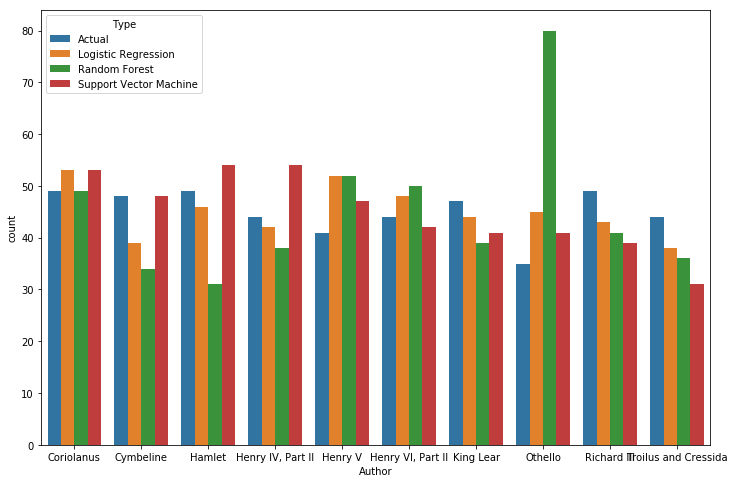

In [23]:
plt.figure(figsize=(12, 8))
log_df_true = pd.DataFrame({'Author': y_test, 'Type': 'Actual'})
log_df_pred = pd.DataFrame({'Author': log_pred, 'Type': 'Logistic Regression'})
gbm_df_pred = pd.DataFrame({'Author': rfc_pred, 'Type': 'Random Forest'})
svm_df_pred = pd.DataFrame({'Author': svm_pred, 'Type': 'Support Vector Machine'})
log_df = pd.concat([log_df_true, log_df_pred, gbm_df_pred, svm_df_pred,])

sns.countplot(x=log_df['Author'].astype('category'), hue=log_df['Type'].astype('category'))
plt.show()

# Conclusion
All 3 models scored close to 75% however only the Support Vector Machine showed somewhat confident results in actual text classification. The support vector machine had the highest highs but fell short in Richard III and Troilus and Cressida where no models seemed to do exceptionally well. Another interesting point to note is the random forest model scored 75% yet performed horribly on every text. Except for Coriolanus where it was the strongest model.

# Clustering with TF-IDF

In [14]:
from sklearn.cluster import KMeans
from sklearn import metrics

kmeans = KMeans(n_clusters=10, n_jobs=-1).fit(X)
kpred = kmeans.predict(X)
labels = kmeans.labels_ 

sil_score = metrics.silhouette_score(X, labels, metric='euclidean')

print(f'Silhouette Score: {sil_score}\n')
pd.crosstab(y, kpred)

Silhouette Score: 0.005219146424782931



col_0,0,1,2,3,4,5,6,7,8,9
Story,,,,,,,,,,
Coriolanus,0,8,37,52,2,51,16,8,1,5
Cymbeline,0,16,16,25,23,23,23,14,22,18
Hamlet,0,10,23,26,11,18,41,6,4,41
"Henry IV, Part II",0,22,11,39,1,34,42,4,2,25
Henry V,15,10,37,11,5,19,60,6,0,17
"Henry VI, Part II",0,22,5,4,8,15,70,16,3,37
King Lear,0,36,13,29,15,19,18,10,10,30
Othello,0,9,5,32,27,30,22,7,26,22
Richard III,0,17,15,6,6,14,35,21,7,59


The silhouette score being so close to 0 means that many of the clusters are overlapping. It seems that we would not be able to assure a high accuracy in predictions by using clusters.

### Graphing Clusters = 10

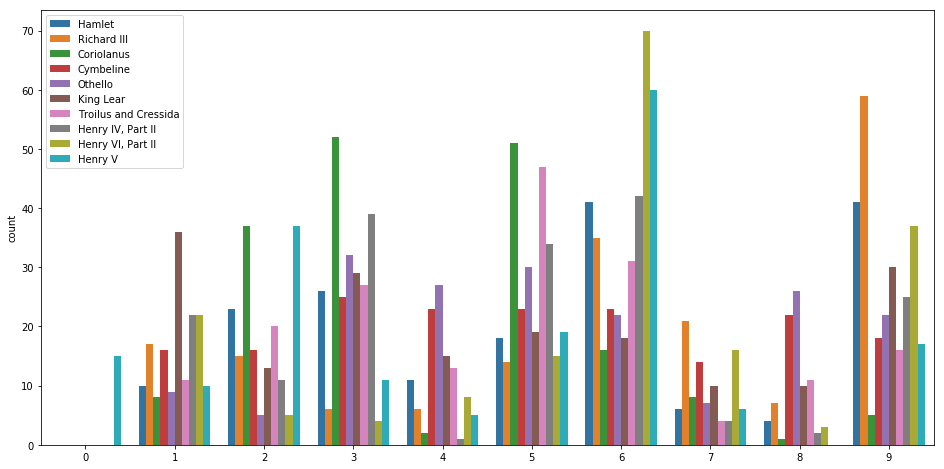

In [30]:
plt.figure(figsize=(16, 8))
sns.countplot(x=kpred, hue=y)
plt.legend(loc='upper left')
plt.show()

### Graphing Clusters = 8

In [34]:
kmeans_8 = KMeans(n_clusters=8, n_jobs=-1).fit(X)
kpred_8 = kmeans_8.predict(X)
labels_8 = kmeans_8.labels_ 

sil_score_8 = metrics.silhouette_score(X, labels, metric='euclidean')

print(f'Silhouette Score: {sil_score_8}\n')

Silhouette Score: 0.005219146424782931



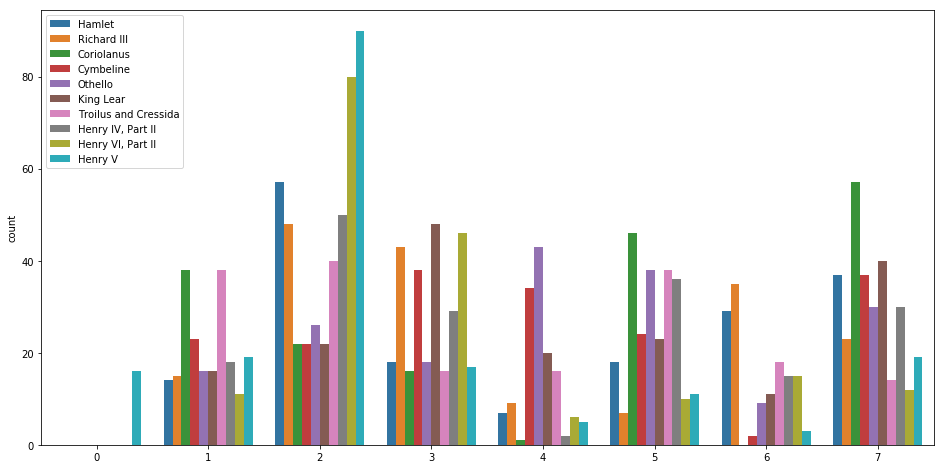

In [35]:
plt.figure(figsize=(16, 8))
sns.countplot(x=kpred_8, hue=y)
plt.legend(loc='upper left')
plt.show()

### Clusters = 6

In [40]:
kmeans_6 = KMeans(n_clusters=6, n_jobs=-1).fit(X)
kpred_6 = kmeans_6.predict(X)
labels_6 = kmeans_6.labels_ 

sil_score_6 = metrics.silhouette_score(X, labels, metric='euclidean')

print(f'Silhouette Score: {sil_score_6}\n')

Silhouette Score: 0.005219146424782931



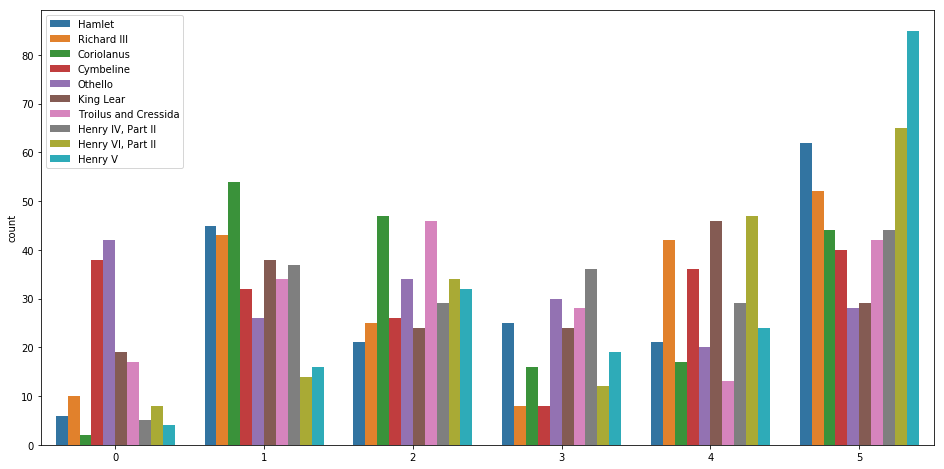

In [41]:
plt.figure(figsize=(16, 8))
sns.countplot(x=kpred_6, hue=y)
plt.legend(loc='upper left')
plt.show()

### Clusters = 12

In [42]:
kmeans_12 = KMeans(n_clusters=12, n_jobs=-1).fit(X)
kpred_12 = kmeans_12.predict(X)
labels_12 = kmeans_12.labels_ 

sil_score_12 = metrics.silhouette_score(X, labels, metric='euclidean')

print(f'Silhouette Score: {sil_score_12}\n')

Silhouette Score: 0.005219146424782931



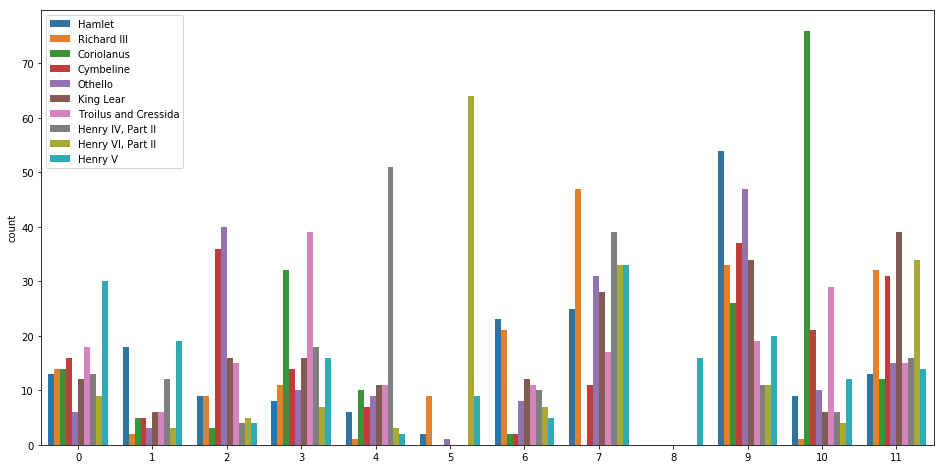

In [43]:
plt.figure(figsize=(16, 8))
sns.countplot(x=kpred_12, hue=y)
plt.legend(loc='upper left')
plt.show()

Overall clustering seems fairly ineffective. Testing various cluster sizes didn't yield any more positive results. Even though cluster 6 has many results from Henry VI, Part II it contains a lot of noise. It would be difficult to correctly label any text on a consistent basis with any of these clusters. Unless it's cluster 0 that contains only text from Henry V.

# LSA - Exploring Similarity

In [46]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(800)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_train)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: ", total_variance*100)

Percent variance captured by all components:  82.44565700832827


### Below we'll see what paragraphs the model considers to be most similar.

In [47]:
paras_df = pd.DataFrame(X_train_lsa, index=X_train_reg)

print(paras_df.loc[:,0].sort_values(ascending=False)[0:10])

Text
[Nor by th' matter which your heart prompts you,, But with such words that are but roted in Your tongue, though but bastards and syllables Of no allowance to your bosom's truth., Now, this no more dishonors you at all Than to take in a town with gentle words, Which else would put you to your fortune and The hazard of much blood. would dissemble with my nature where My fortunes and my friends at stake required should do so in honor., am in this Your wife, your son, these senators, the nobles; And you will rather show our general louts How you can frown than spend a fawn upon 'em For the inheritance of their loves and safeguard Of what that want might ruin., Noble lady!, Come, go with us; speak fair., You may salve so, Not what is dangerous present, but the loss Of what is past., prithee now, my son, Go to them with this bonnet in thy hand, And thus far having stretched it here be with them Thy knee bussing the stones for in such business Action is eloquence, and the eyes of th' ign

# Word2Vec

In [57]:
import gensim
import nltk

# Tokenizing text 
vec_sents = list(pdf['Text'])
vec_sents = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(str(vec_sents))]

# Creating Word2Vec model
w2v = gensim.models.Word2Vec(size=150, window=10, min_count=2, sg=1, workers=10)
w2v.build_vocab(vec_sents)
w2v.train(sentences=vec_sents, total_examples=len(vec_sents), epochs=w2v.epochs)

(854407, 1291800)

### Exploring some word similarities. 

In [72]:
w2v.wv.most_similar(positive='lord', topn=5)

[('lord.', 0.8820561170578003),
 ('uncle', 0.8602159023284912),
 ('cousin', 0.8567171096801758),
 ('liege', 0.8304941058158875),
 ('Good', 0.8301956653594971)]

In [74]:
w2v.wv.most_similar(positive='Hamlet', topn=5)

[('fares', 0.9741405248641968),
 ('Horatio', 0.9630932807922363),
 ('Majesty.', 0.9577731490135193),
 ('Hamlet.', 0.9553756713867188),
 ('cousin', 0.9525052309036255)]

In [79]:
w2v.wv.most_similar(positive='prince', topn=5)

[('Doth', 0.9397165775299072),
 ('double', 0.9395380020141602),
 ('traitor', 0.9395298957824707),
 ('duke', 0.9375977516174316),
 ('ambition', 0.9361156225204468)]

In [78]:
w2v.wv.most_similar(positive='queen', topn=5)

[('traitor', 0.92766934633255),
 ('prince', 0.9213409423828125),
 ('Plantagenet', 0.9203892350196838),
 ('young', 0.9130967259407043),
 ('Harry', 0.9125118851661682)]

It's interesting to see that traitor appeared in both queen and prince. It would be interesting to see which texts contributed most to these word vector associations.

# Conclusion

Overall unsupervised methods seemed to be an ineffective approach for this task. While I personally found the results very interesting there isn't a lot of weight to them in terms of classification accuracy. The supervised learning segment performed fairly well with difficult data. Had the speaking queues been left in I'm sure they would have scored even better than they did.